# Assignment 2: Cell Tower Installation

## Instructions

This assignment is worth 10/100 points. 

You can do this assignment with someone else and it is about Local Search Algorithms, more specifically, Genetic Algorithms.

Answer to all the questions in english, argument, and justify your answers using the obtained results.

### Names

- Nicolas Cari Rodriguez
- Christian Rivero Arnez

### Deadline
March 18th, 2023 at 23.59

### Some more Instructions
- You need to fill in your answers here and submit this jupyter notebook via NEO.
- It should run smoothly.
- Any compilation error will affect your total score. 


### Important before starting! 

- Only one of you should send the assignment, NOT BOTH!
- DO NOT copy the answers from internet nor from your classmates.
- If there are two or more groups that were discovered cheeting, then they will be penalized with 0/10.
- Use your brain and the material seen in class to program this assignment.
- You should be able to explain and modify your code according to your (or my) needs. 

## Problem Description
A local cellphone bolivian company wants to give cell phone signal to $n$ cities located in a remote place somewhere in Bolivia. 

They want to install cell towers that gives signal for $r$ Km around. The cost of installing a tower on land is not the same as the cost of installing it on a lake or on top of a hill. Thus, they want to minimize the amount of towers to be used and also the cost to be spent by installing each of them while giving signal to all cities (total coverage) such as in the picture below where we can see that all cities are covered. 

<div>
<img src="img/cities.png" width="500"/>
</div>


We will suppose that the signal radius of each tower is the same, independently if the tower is on top of a hill or on the land. 

### Some code to help you focus on the important part

We have already implemented part of the code to help you deal with some aspects of the problem such as the map representation, the cell tower coverage, part of the chromosome representation. 

In [1]:
import numpy as np
import random
from enum import Enum, auto
import copy
from matplotlib import colors, pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pickle

In [2]:
class Chromosome: 
    rows = 0 
    cols = 0
    
    def __init__(self, gens):
        self.gens = gens
        self.FitnessValue=0
        # fitness function can be defined outside the class
        #self.ind_fitness = self.__class__.fitness_function(self.get_coordinates())
    def __gt__(self,otherChromosome):
        return self.FitnessValue>otherChromosome.FitnessValue
    @classmethod
    def generate_random(cls, tower_pr):
        '''
            It generates a random chromosome
            tower_pr is the probability to add a tower to a certain position
            higher this amount more towers you will have
            lower this amount less towers you will have
        '''
        gens = [0] * cls.rows * cls.cols 
        for i in range(cls.rows * cls.cols): 
            if random.random() < tower_pr:
                # indicates the presence of a tower
                gens[i] = 1 
        
        return Chromosome(gens)   

    @classmethod 
    def set_fitness_function(cls, fun): 
        cls.fitness_function = fun

    def count_towers(self): 
        return sum(self.gens)  

    def get_coordinates(self): 
        ''' Maps gens to map coordinates '''
        r = self.__class__.rows 
        c = self.__class__.cols 
        matrix = [[None] * c for _ in range(r)] 
        
        for i in range(r): 
            for j in range(c): 
                matrix[i][j] = self.gens[i * r + j] 
        
        return np.array(matrix)
          
            

In [3]:
class SquareType(Enum): 
    water = auto() 
    land = auto() 
    hill = auto() 
    city = auto()

In [4]:
class Square: 
    def __init__(self, type, needs_coverage, tower_cost, is_covered = False): 
        self.tower_cost = tower_cost 
        self.needs_coverage = needs_coverage
        self.is_covered = is_covered 
        self.type = type 
        self.has_radar = False

In [5]:
class Landscape:
    def __init__(self, matrix): 
        self.matrix = matrix 
        self.costOfTowersAdded=0
    
    def rows(self): 
        return len(self.matrix) 
    
    def cols(self): 
        return len(self.matrix[0])
    
    def addToTowerCost(self,x,y):
        square=self.matrix[y][x]
        self.costOfTowersAdded+=square.tower_cost
      
        
        
    def add_towers(self, centroids, radius):
        r = radius
        
        for idx, x in np.ndenumerate(centroids):
            if centroids[idx[0],idx[1]] == 1:
                a, b = idx[0], idx[1]
                self.matrix[a][b].has_radar = True
                self.addToTowerCost(a,b)
                # draw the circle
                for y in range(self.rows()):
                    for x in range(self.cols()):
                        # see if we're close to (x-a)**2 + (y-b)**2 == r**2
                        if abs((x-a)**2 + (y-b)**2) <= r**2:
                            self.matrix[y][x].is_covered = True
                            
    def uncovered_count(self):
        '''uncovered cities'''
        count = 0
        
        for y in range(self.rows()):
            for x in range(self.cols()):
                if self.matrix[y][x].type == SquareType.city and self.matrix[y][x].is_covered == False:
                    count+=1
        return count

In [6]:
def generate_random_landscape(points, weights, rows, cols): 
    matrix = [[None] * cols for _ in range(rows)] 
    for i in range(rows): 
        for j in range(cols): 
            p = random.choices(points, weights.values()) 
            square = copy.deepcopy(p[0])
            
            square.tower_cost = square.tower_cost #round(square.tower_cost * (1 + random.uniform(0, .1))) 
            matrix[i][j] = square 
    
    return Landscape(matrix)

plt.rcParams['figure.figsize'] = [5,5]

def plot_landscape(landscape): 
    square_colors = { 
        SquareType.water: 1, 
        SquareType.land: 11, 
        SquareType.hill: 21, 
        SquareType.city: 31
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()):
        for j in range(landscape.cols()):
            m[i, j] = square_colors[landscape.matrix[i][j].type]
            
    col_list = ['blue', 'green', 'brown', 'black']
    labels = [s.name for s in square_colors.keys()] 
    cmap = colors.ListedColormap(col_list)
    bounds = [0, 10, 20, 30, 40] 
    norm = colors.BoundaryNorm(bounds, cmap.N) 
            
    plt.imshow(m, cmap = cmap, norm = norm) 
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1) 
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.3, 1), borderaxespad = 0.)
    plt.title('Landscape')
    plt.show()
    
def plot_coverage(landscape, title = "Coverage"):
    coverage_colors = { 
        'neutral': 1, 
        'is covered': 11, 
        'needs coverage': 21 
    }
    
    m = np.empty([landscape.rows(), landscape.cols()])
    for i in range(landscape.rows()):
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].is_covered: 
                m[i, j] = coverage_colors['is covered'] 
            elif not landscape.matrix[i][j].needs_coverage: 
                m[i, j] = coverage_colors['neutral'] 
            elif landscape.matrix[i][j].needs_coverage:
                m[i, j] = coverage_colors['needs coverage']

    col_list = ['white', 'yellow', 'black'] 
    labels = list(coverage_colors.keys()) 
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20, 30] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.grid(which = 'major', axis = 'both', linestyle = '--', color = 'k', linewidth = 1)
    patches = [mpatches.Patch(color = col_list[i], label = labels[i]) for i in range(len(col_list))]
    plt.legend(handles = patches, bbox_to_anchor=(1.5, 1), borderaxespad = 0.)
    plt.title('Coverage')
    plt.show() 

def plot_costs(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            m[i, j] = landscape.matrix[i][j].tower_cost 
    plt.imshow(m, cmap = plt.cm.Reds)
    plt.colorbar()
    plt.title('Tower Construction Costs')
    plt.show()
    
def plot_towers_position(landscape): 
    m = np.empty([landscape.rows(), landscape.cols()])
    
    for i in range(landscape.rows()): 
        for j in range(landscape.cols()): 
            if landscape.matrix[i][j].has_radar:
                m[j, i] = 11
            else:
                m[j, i] = 1

    col_list = ['white','black']
    cmap = colors.ListedColormap(col_list) 
    bounds = [0, 10, 20] 
    norm = colors.BoundaryNorm(bounds, cmap.N)
                
    plt.imshow(m, cmap = cmap, norm = norm)
    plt.title('Towers Position')
    plt.show()

The cost of installing a cell tower on:
- Water (such as lakes): \$us 300K
- City: \$us 200K
- Hill: \$us 100K
- Land: \$us 30K

Each tower has a coverage of 7 Km around it.

# F: -3810
# Cell Towers: 6
# Cost: 590
Uncovered Cities before cell towers: 30
Uncovered Cities after cell towers: 24


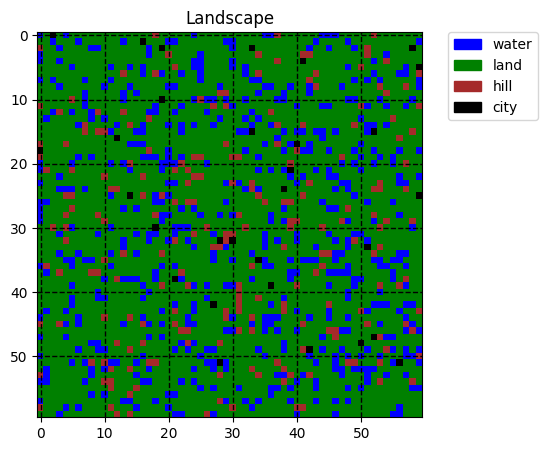

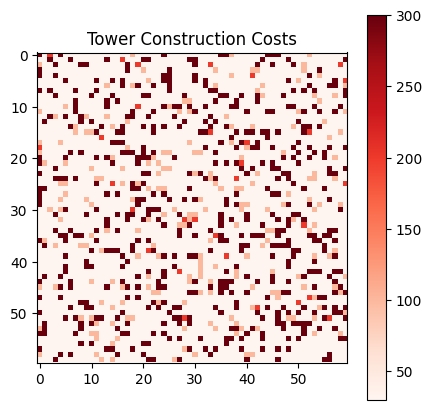

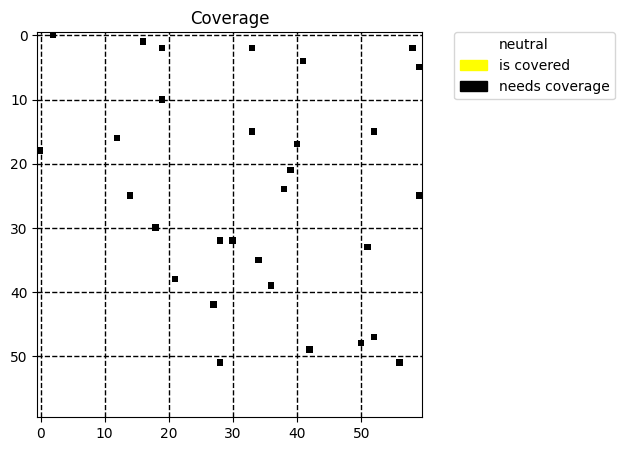

Coverage after setting up the cell towers:


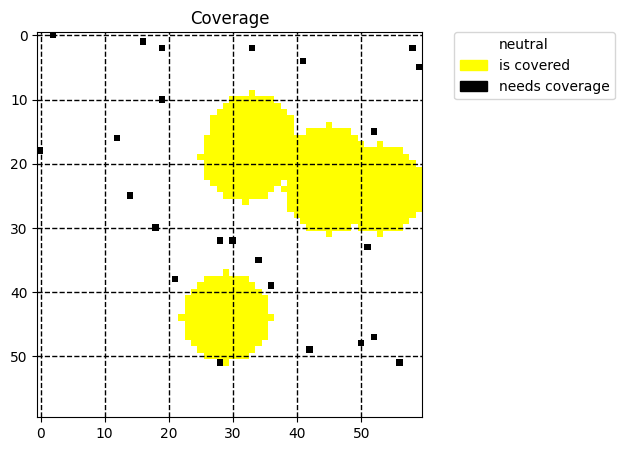

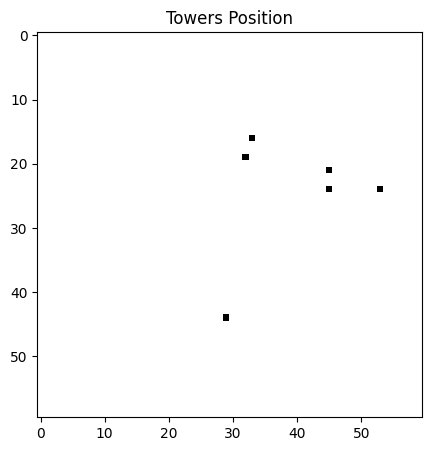

In [7]:
# the purpose of this line is to reproduce your results
random.seed(15)
random.random()

# map dimension:
rows = 60
cols = 60

square_grid = { 
    Square(SquareType.water, needs_coverage = False, tower_cost = 300): 20,
    Square(SquareType.city, needs_coverage = True, tower_cost = 200): 1,
    Square(SquareType.hill, needs_coverage = False, tower_cost = 100): 8,
    Square(SquareType.land, needs_coverage = False, tower_cost = 30): 100
}

landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

Chromosome.rows = rows
Chromosome.cols = cols

# fitness function undefined yet 
def fitness_function(cr,worstCostOfPopulation,penalty=100): 
    return cr.cost-worstCostOfPopulation-cr.uncovered*penalty

Chromosome.set_fitness_function(fitness_function) 
cr = Chromosome.generate_random(.001)

test_landscape = copy.deepcopy(landscape) 
# coverage of 7km
test_landscape.add_towers(cr.get_coordinates(), 7)

towers = cr.count_towers() 
cr.uncovered = test_landscape.uncovered_count() 
cr.cost=test_landscape.costOfTowersAdded
F=cr.fitness_function(2000)
print(f'# F: {F}') 
print(f'# Cell Towers: {towers}') 
print(f'# Cost: {cr.cost}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {cr.uncovered}')

plot_landscape(landscape) 
plot_costs(landscape) 
plot_coverage(landscape)

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

In [8]:
#Generating Landscape
rows = 60
cols = 60
Chromosome.rows = rows
Chromosome.cols = cols
#landscape = generate_random_landscape(list(square_grid.keys()), square_grid, rows, cols)

In [9]:
#Saving Landscape
def save_object(obj,fileName):
    try:
        with open(fileName+".pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)
 
#save_object(landscape,"landscapeToTest")

In [10]:
#Load Landscape
def loadObject(fileName):
    file = open(fileName,'rb')
    obj = pickle.load(file)
    file.close()
    return obj
landscape=loadObject("landscapeToTest.pickle")

In [11]:
def fitness_function(cr,cities,worstValueOfPopulation,buff=3000): 
    f=-cr.cost+worstValueOfPopulation+(cities-cr.uncovered)*buff
    
    return f

Chromosome.set_fitness_function(fitness_function) 

def addSubstr(arr1,arr2,initIndex,endIndex):
    if(endIndex==-1):
        arr1+=arr2[initIndex::]
    else:
        arr1+=arr2[initIndex:endIndex]
    return arr1
def crossover(parent1, parent2,points=4,SuccessProbability=0.7):
    parent1=parent1.gens.copy()
    parent2=parent2.gens.copy()
    if random.randint(0,1)>SuccessProbability:
        return parent1,parent2
    
    crossover_points=sorted(random.sample(range(len(parent1)), points))
    crossover_points.append(-1)
    child1=[]
    child2=[]
    order=0
    lastPoint=0
    for point in crossover_points:
        if order==0:
            addSubstr(child1,parent1,lastPoint,point)
            addSubstr(child2,parent2,lastPoint,point)
            order=1
        else:
            addSubstr(child1,parent2,lastPoint,point)
            addSubstr(child2,parent1,lastPoint,point)
            order=0
        lastPoint=point
    return child1,child2
def mutateGen(gens,mutationProb=0.1):
    if random.randint(0,1)>mutationProb:
        return gens
    genIndex=random.sample(range(len(gens)), 1)[0]
    if gens[genIndex]==0:
        gens[genIndex]=1
    else:
        gens[genIndex]=0
    return gens
def calculateCostAndUncovered(cr,landscape):
    landscapeCopy = copy.deepcopy(landscape) 
    landscapeCopy.add_towers(cr.get_coordinates(), 7)
    return  landscapeCopy.costOfTowersAdded,landscapeCopy.uncovered_count()
def geneticAlgorithm(landscape,cities,runTimes=140,P=20,probToGenerateTower=0.0001,mutationProb=0.1,crossoverProb=0.7,buffPerCity=3000,crossoverPoints=2):
    basePopulation=[]
    ansArray=[]
    for _ in range(P):
        newCr=Chromosome.generate_random(probToGenerateTower)
        basePopulation.append(newCr)
    for rt in range(runTimes):
        probabilities=[]
        worstValueOfPopulation=0
        FitnessOfPopulation=0
        bestPopulationChromosome=None
        for cr in basePopulation:
            cr.cost,cr.uncovered=calculateCostAndUncovered(cr,landscape)
            if cr.cost>worstValueOfPopulation:
                worstValueOfPopulation=cr.cost
        for cr in basePopulation:
            cr.FitnessValue=cr.fitness_function(cities,worstValueOfPopulation,buffPerCity)
            FitnessOfPopulation+=cr.FitnessValue
        if(FitnessOfPopulation==0):
            FitnessOfPopulation=1
        for cr in basePopulation:
            probabilities.append(cr.FitnessValue/FitnessOfPopulation)
        newPopulation=[]
        while len(newPopulation)!=P:
            cr1,cr2=np.random.choice(basePopulation,2,p=probabilities)
            crx,crz=crossover(cr1,cr2,crossoverPoints,crossoverProb)
            crx=mutateGen(crx,mutationProb)
            crz=mutateGen(crz,mutationProb)
            
            newPopulation.append(Chromosome(crx))
            if(len(newPopulation)!=P):
                newPopulation.append(Chromosome(crz))
        bestPopulationChromosome=max(basePopulation)
        basePopulation=newPopulation
        #print(rt,FitnessOfPopulation,bestPopulationChromosome.uncovered)
        ansArray.append(FitnessOfPopulation)
    return bestPopulationChromosome,ansArray
print("cities:",landscape.uncovered_count())
#bestGen,arrayParaver=geneticAlgorithm(landscape,landscape.uncovered_count())
#print(bestGen.__dict__)

cities: 27


### change for each iteration we want to see information of

In [12]:
crossoverPoints=2
crossoverProb=0.5
mutationProb=0.15
buffPerCity=3000
P=40
bestGen,arrayParaver=geneticAlgorithm(landscape,landscape.uncovered_count(),P=P,crossoverPoints=crossoverPoints,mutationProb=mutationProb,crossoverProb=crossoverProb,buffPerCity=buffPerCity)

In [13]:
save_object(arrayParaver,"PopulationRunAllCells")

# Cell Towers: 91
# Cost: 5660
Uncovered Cities before cell towers: 27
Uncovered Cities after cell towers: 0


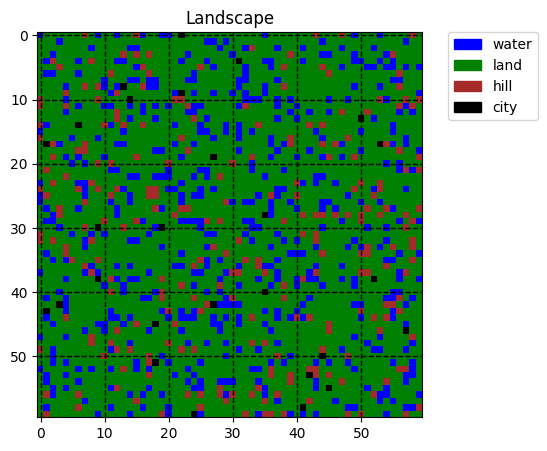

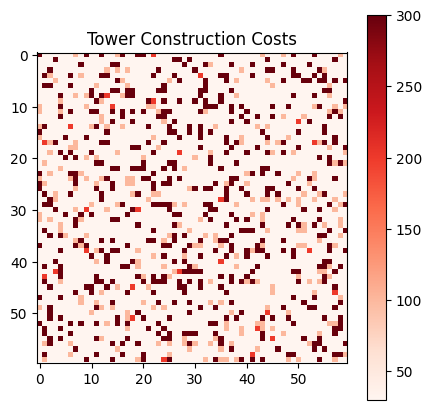

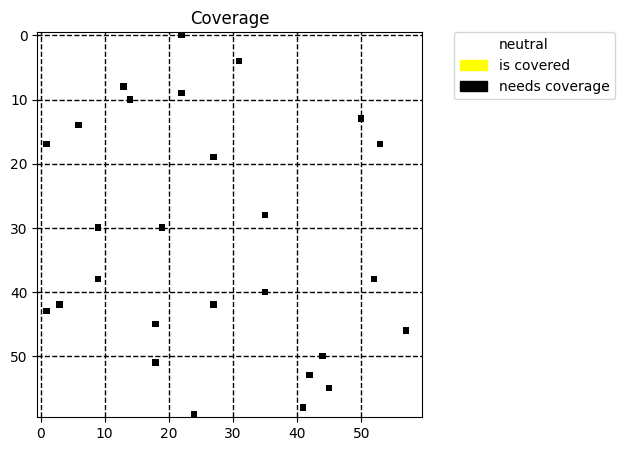

Coverage after setting up the cell towers:


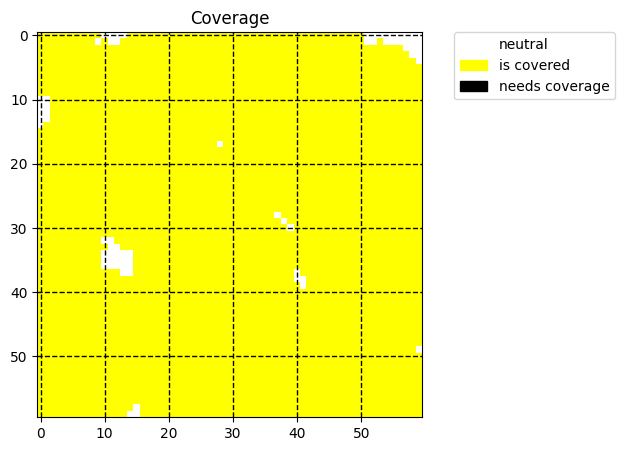

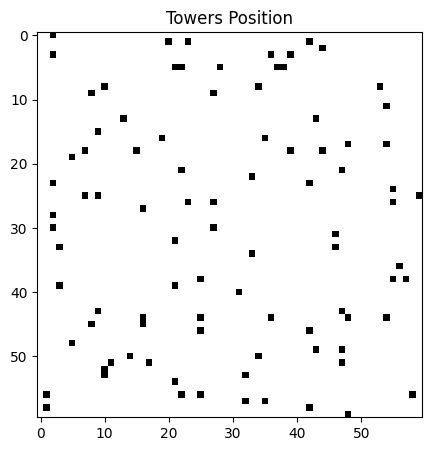

In [14]:

test_landscape = copy.deepcopy(landscape) 
test_landscape.add_towers(bestGen.get_coordinates(), 7)
towers = bestGen.count_towers() 
cost=test_landscape.costOfTowersAdded
print(f'# Cell Towers: {towers}') 
print(f'# Cost: {cost}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {bestGen.uncovered}')

plot_landscape(landscape) 
plot_costs(landscape) 
plot_coverage(landscape)

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

In [15]:
matrix=[]
runTimes=0
generations=200
P=20
for _ in range(runTimes):
    bestGen,arrayParaver=geneticAlgorithm(landscape,landscape.uncovered_count(),generations,P)
    print("Finished run")
    matrix.append(arrayParaver)


In [16]:

def save_object(obj):
    try:
        with open("matrixWRuntimes2.pickle", "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    except Exception as ex:
        print("Error during pickling object (Possibly unsupported):", ex)
 
#save_object(matrix)

In [17]:
def calculate_average_fitness_and_uncovered(matrix, runTimes=5, P=20):
    AverageFitness=[]
    AverageUncovered=[]
    for generation in range(len(matrix[1])):
        valueAvg=0
        valueAvgUncovered=0
        for rT in range(runTimes):
            valueAvg+=matrix[rT][generation][0]
            valueAvgUncovered+=matrix[rT][generation][1]
        valueAvg=valueAvg/(runTimes*P)
        valueAvgUncovered=valueAvgUncovered/runTimes
        AverageFitness.append(valueAvg)
        AverageUncovered.append(valueAvgUncovered)
    
    return AverageFitness,AverageUncovered
#print(AverageFitness)
#print(AverageUncovered)
#file = open("matrixWRuntimes2.pickle",'rb')
#matrix = pickle.load(file)
#file.close()
#AverageFitness, AverageUncovered = calculate_average_fitness_and_uncovered(matrix)

## Tasks

1. Explain how you plan to use genetic algorithms to solve this problem and how your solution will work.
2. Implement a genetic algorithm to solve the problem. Plot the average fitness of the population for each generation.
3. Use different settings for the algorithm parameters (such as $p_c$, $p_m$, size of the population), report and disscuss your results. 
4. How does your solution look like? How many cell towers we need to use? What is the total cost of installing all of these? 

# Answer 1

We plan to use genetic algorithms to take a random input value and train it using evolution techniques seen in class, such as selection, crossover, and mutation to create new solutions, improving our fitness, and thus our result.

We will use selection to choose a chromosome based on the population's fitness, with a better fitness having more chance. This will attempt to find solutions where less money is spent, and the maximum coverage is achieved.

We will use crossover to exchange genetic material between two chromosomes to generate new chromosomes. In this case, the genes of the chromosomes represent 0 and 1, indicating the absence or presence of a tower. When performing crossover, we will exchange a part of this genetic material, which represents the location of the towers.

We will use mutation to select a bit of the chromosome randomly and change it. In this case, we remove or add a tower on our map to obtain similar but not identical solutions, to avoid staying in one response and search for solutions that may be slightly better.

Our solution will work by using a fitness identified as the construction cost of the towers and the coverage of all cities.

To ensure that our answer is correct, we will change our crossover methods, and if necessary, our fitness, to ensure that the answer we obtain is correct.

# Answer 2

We used our genetic algorithm to find the next solution:

<div>
<img src="img/fitnessVsIterationRuntime2.png" width="500"/>
</div>

We achieved this by running the algorithm 200 times for 5 sessions, obtaining the average of the results between these sessions. We can analyze that if we run the same thing many times, it always stagnates in the 140th iteration, and the values do not improve from there.

<div>
<img src="img/uncoveredVsIterationRuntime2.png" width="500"/>
</div>

We can also note that the cities without coverage reach 1 and shortly after 0, so we cannot maximize the fitness beyond the result found in our 120th iteration.

To test if this result is correct, we did the same thing but now we changed our crossover function. Instead of using 2 points, we used 5 points. In this case, we got the following graph:

<div>
<img src="img/fitnessVsIterationRuntime3.png" width="500"/>
</div>

Here we can see that our fitness does not reach values higher than we did with a 2-point crossover, indicating that using 2 points is better than using 5 points because using 2 points used less resources and time, witohut losing accuracy.

<div>
<img src="img/uncoveredVsIterationRuntime3.png" width="500"/>
</div>

We also see that the best result was found by the 140th iteration, and then the other results did not improve. Therefore, even if the best result is not found, we make sure that the algorithm runs optimally 140 times before stagnating.

entonces al hacer correr nuestro algoritmo obtenemos el siguiente resultado:

In [192]:
crossoverPoints=2
crossoverProb=0.7
mutationProb=0.1
buffPerCity=3000
P=20
bestGen,arrayParaver=geneticAlgorithm(landscape,landscape.uncovered_count(),P=P,crossoverPoints=crossoverPoints,mutationProb=mutationProb,crossoverProb=crossoverProb,buffPerCity=buffPerCity)

# Cell Towers: 82
# Cost: 6590
Uncovered Cities before cell towers: 27
Uncovered Cities after cell towers: 0
Coverage after setting up the cell towers:


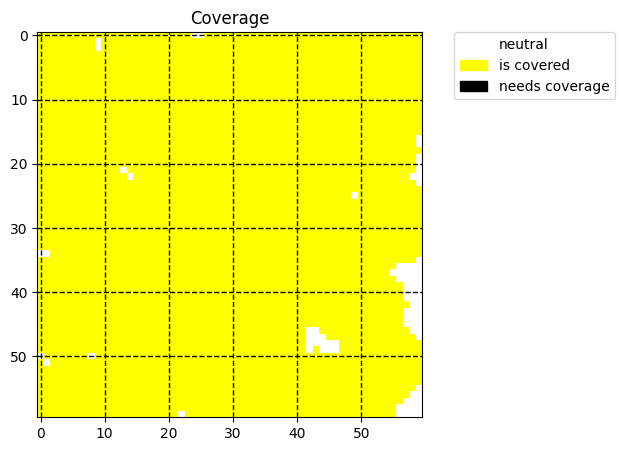

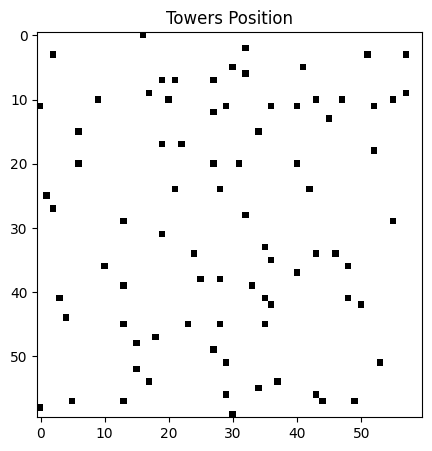

In [193]:
test_landscape = copy.deepcopy(landscape) 
test_landscape.add_towers(bestGen.get_coordinates(), 7)
towers = bestGen.count_towers() 
cost=test_landscape.costOfTowersAdded
print(f'# Cell Towers: {towers}') 
print(f'# Cost: {cost}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {bestGen.uncovered}')

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

# Answer 3


To ensure that the result we found is the best result, we will first change the number of crossover points we have, and by doing this, we have the following results:

<div>
<img src="img/crossoverPoints.png" width="500"/>
</div>

By looking at the graph, we can realize that it is better to work using 2 crossover points since our results on average perform better, seeing a much bigger difference at the beginning but still maintaining a slight advantage in future iterations.

Regarding the crossover probability, we saw that using higher probabilities of crossover is better in our first iterations, but using a 50% probability over 100 iterations is even better than the others in finding an optimal result. Although we can also see that the difference is minimal and this will not greatly affect the result, similar crossover probabilities can be used, and the result will change in very small amounts.

<div>
<img src="img/probabilities.png" width="500"/>
</div>

If we look at mutation, we can notice that the values do not affect the fitness much while not using an extremely small mutation rate like 5% or 1%. However, it does not increase significantly with a difference of 15% or 20%. Therefore, either of the two can be chosen, and we chose 15% because it gave us better results during all iterations, albeit by a tiny margin.

<div>
<img src="img/mutation.png" width="500"/>
</div>

Regarding the population, increasing the population by 10 or 20 chromosomes does not increase the result much. In this case, to keep the fitness constant by population, we are showing the average of the population for each iteration, and we can see that the values are similar, and thus it is not convenient to increase the population by 1000 chromosomes trying to find a better result. That would take a lot of time and resources and would give us a very similar result to what we have obtained.

<div>
<img src="img/population.png" width="500"/>
</div>

Taking into account the time used by the algorithm and the difference in fitness, it was decided to use 50 chromosomes as the population.

# Answer 4

Using the optimal parameters seen in our previous experiments:

In [190]:
crossoverPoints=2
crossoverProb=0.5
mutationProb=0.15
buffPerCity=3000
P=50
bestGen,arrayParaver=geneticAlgorithm(landscape,landscape.uncovered_count(),P=P,crossoverPoints=crossoverPoints,mutationProb=mutationProb,crossoverProb=crossoverProb,buffPerCity=buffPerCity)

# Cell Towers: 78
# Cost: 6030
Uncovered Cities before cell towers: 27
Uncovered Cities after cell towers: 0


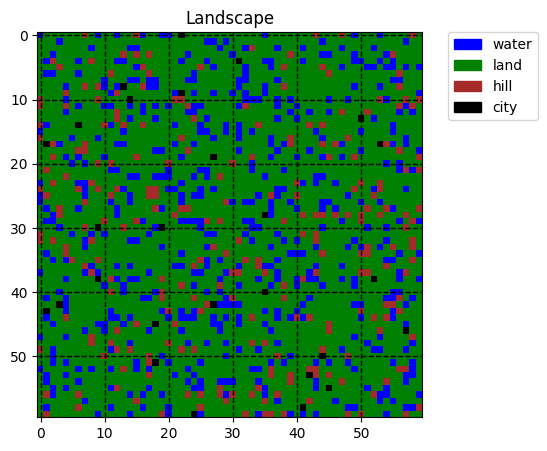

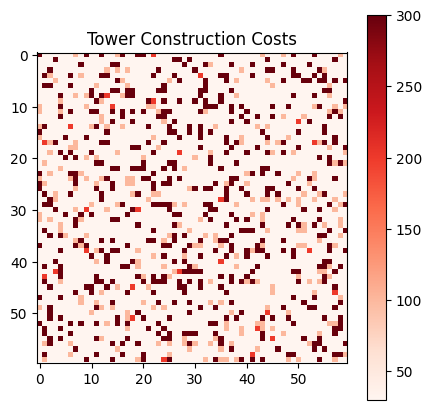

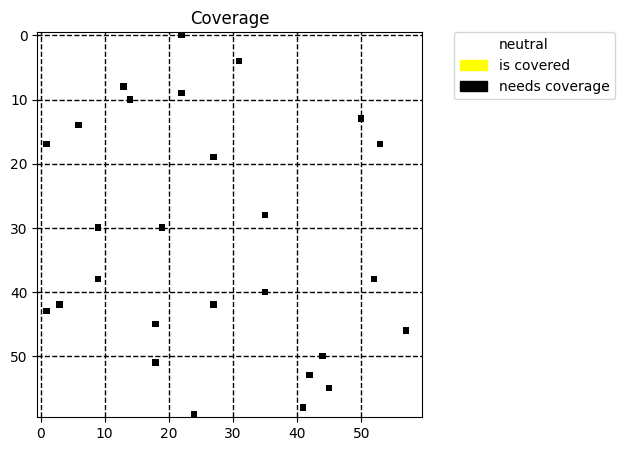

Coverage after setting up the cell towers:


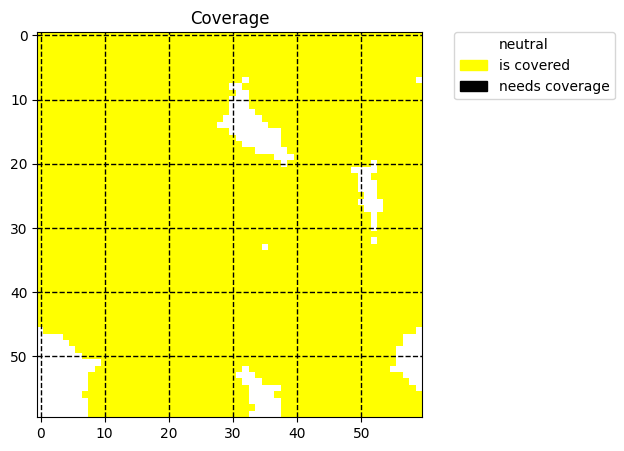

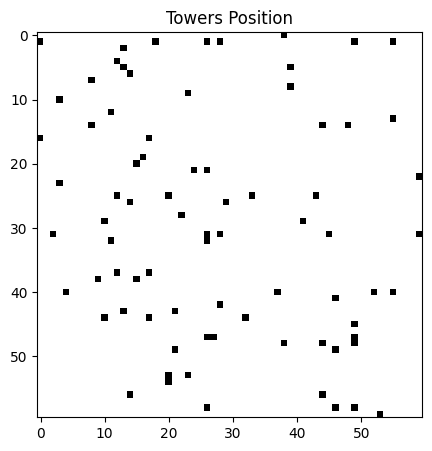

In [191]:
test_landscape = copy.deepcopy(landscape) 
test_landscape.add_towers(bestGen.get_coordinates(), 7)
towers = bestGen.count_towers() 
cost=test_landscape.costOfTowersAdded
print(f'# Cell Towers: {towers}') 
print(f'# Cost: {cost}') 
print(f'Uncovered Cities before cell towers: {landscape.uncovered_count()}')
print(f'Uncovered Cities after cell towers: {bestGen.uncovered}')

plot_landscape(landscape) 
plot_costs(landscape) 
plot_coverage(landscape)

print('Coverage after setting up the cell towers:')
plot_coverage(test_landscape) 
plot_towers_position(test_landscape)

We can see that by comparing the first result we obtained, we had a cost of $6,590,000, but after updating our crossover and mutation probabilities, we found an even better result than the first one: $6,030,000.

With this, we managed to find a valid result in our first approach, but by improving the parameters seen in point 3, we were able to improve this result with a gain of $500,000.